# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "fundamentals"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Lineare Regression: Macht Geld glücklich?

aus: Géron: Hands-on Machine Learning with Scikit-Learn and TensorFlow

In [4]:
def prepare_country_stats(oecd_bli, gdp_per_capita):
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    
    return full_country_stats[["GDP per capita", 'Life satisfaction']]

In [5]:
import os
#path = "/content/drive/My Drive/Colab Notebooks/ML/01_LinReg"
path = "./"
datapath = os.path.join(path, "datasets", "lifesat", "")

In [7]:
# Code example
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

# Load the data
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv(datapath + "gdp_per_capita.csv",thousands=',',delimiter='\t',
                             encoding='latin1', na_values="n/a")

# Prepare the data
remove_indices = [0, 1, 6, 8, 33, 34, 35]
keep_indices = list(set(range(36)) - set(remove_indices))
full_country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
country_stats = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]
Xsample = np.c_[country_stats["GDP per capita"]]
ysample = np.c_[country_stats["Life satisfaction"]]

In [8]:
ysample

array([[6. ],
       [5.6],
       [4.9],
       [5.8],
       [6.1],
       [5.6],
       [4.8],
       [5.1],
       [5.7],
       [6.5],
       [5.8],
       [6. ],
       [5.9],
       [7.4],
       [7.3],
       [6.5],
       [6.9],
       [7. ],
       [7.4],
       [7.3],
       [7.3],
       [6.9],
       [6.8],
       [7.2],
       [7.5],
       [7.3],
       [7. ],
       [7.5],
       [7.2]])

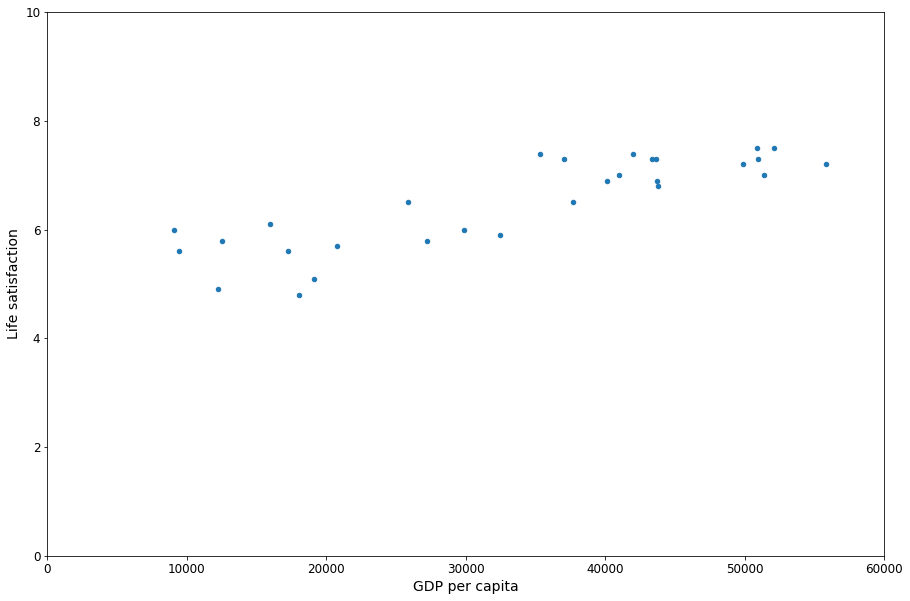

In [9]:
# Visualize the data
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(15,10))
plt.axis([0, 60000, 0, 10])
plt.show()

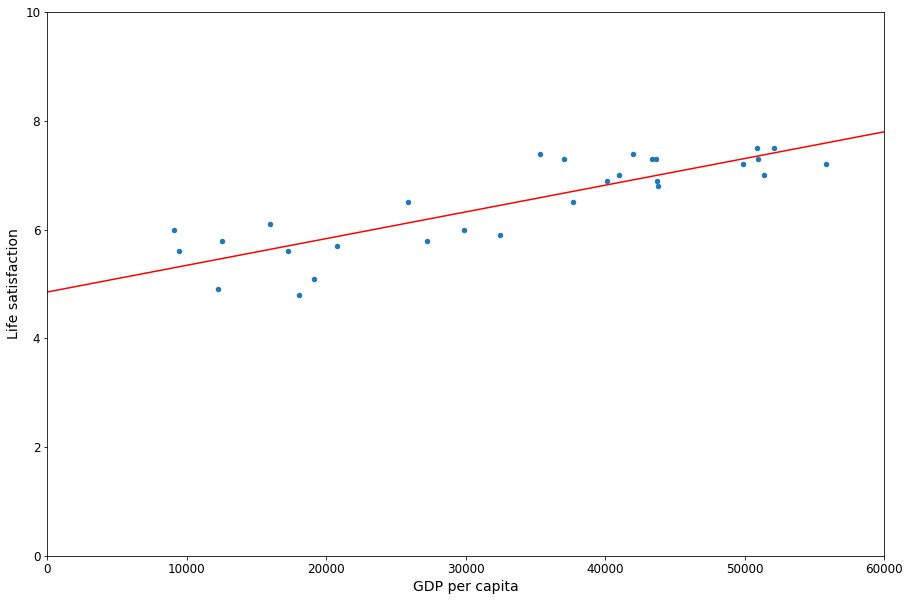

In [10]:
from sklearn import linear_model
lin1 = linear_model.LinearRegression()
lin1.fit(Xsample, ysample)
t0, t1 = lin1.intercept_[0], lin1.coef_[0][0]
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(15,10))
plt.axis([0, 60000, 0, 10])
X=np.linspace(0, 60000, 1000)
plt.plot(X, t0 + t1*X, "red")
plt.show()

# Wir haben keinen Better Life Index von Zypern. Aber das GDP...

Hier kommt das Modell ins Spiel.

In [11]:
cyprus_gdp_per_capita = gdp_per_capita.loc["Cyprus"]["GDP per capita"]
print(cyprus_gdp_per_capita)
cyprus_predicted_life_satisfaction = lin1.predict([[cyprus_gdp_per_capita]])[0][0]
cyprus_predicted_life_satisfaction

22587.49


5.96244744318815

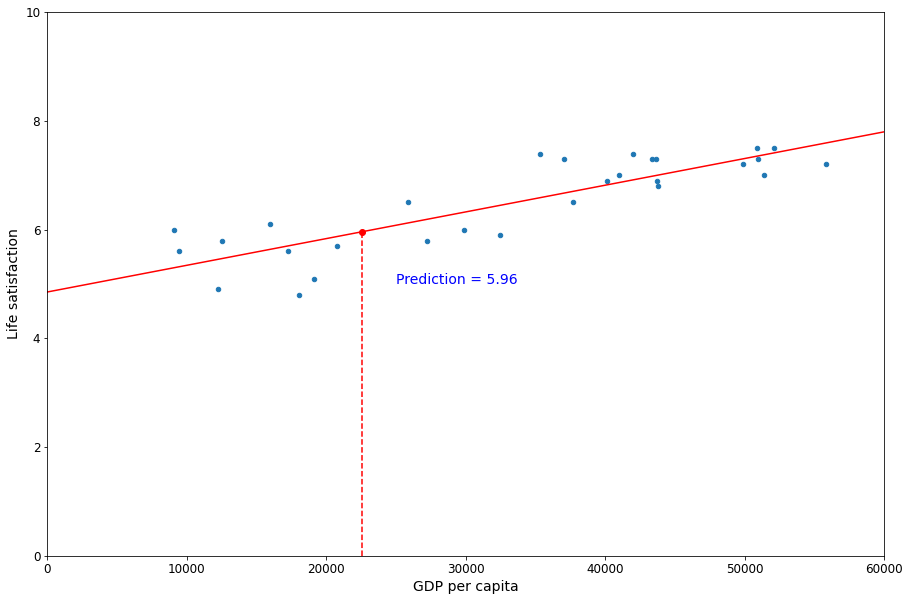

In [12]:
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(15,10))
X=np.linspace(0, 60000, 1000)
plt.plot(X, t0 + t1*X, "red")
plt.axis([0, 60000, 0, 10])
plt.plot([cyprus_gdp_per_capita, cyprus_gdp_per_capita], [0, cyprus_predicted_life_satisfaction], "r--")
plt.text(25000, 5.0, r"Prediction = 5.96", fontsize=14, color="b")
plt.plot(cyprus_gdp_per_capita, cyprus_predicted_life_satisfaction, "ro")
plt.show()

# Mögliche Probleme:

In [13]:
missing_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[remove_indices]
missing_data

,GDP per capita,Life satisfaction
Country,,
Brazil,8669.998,7.0
Mexico,9009.280,6.7
Chile,13340.905,6.7
Czech Republic,17256.918,6.5
Norway,74822.106,7.4
Switzerland,80675.308,7.5
Luxembourg,101994.093,6.9


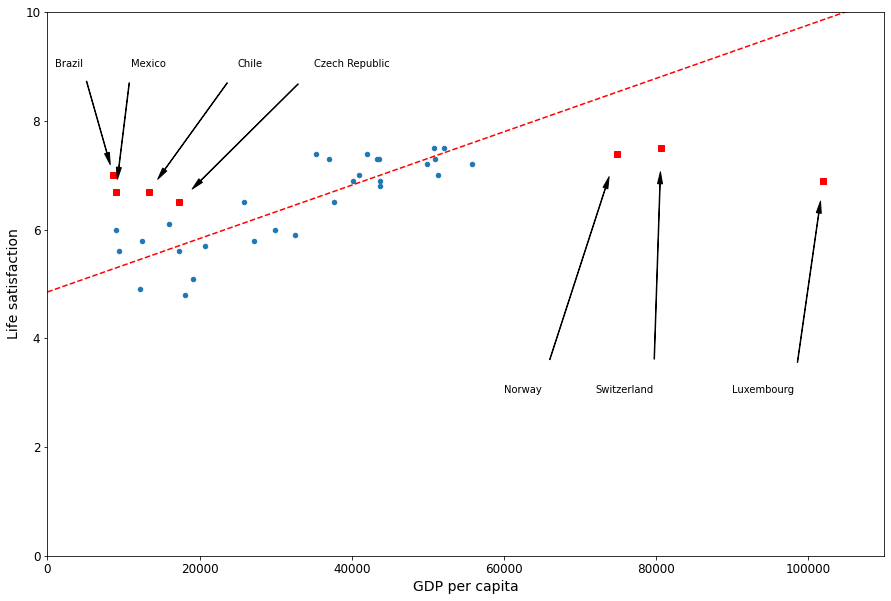

In [14]:
position_text2 = {
    "Brazil": (1000, 9.0),

    "Mexico": (11000, 9.0),
    "Chile": (25000, 9.0),
    "Czech Republic": (35000, 9.0),
    "Norway": (60000, 3),
    "Switzerland": (72000, 3.0),
    "Luxembourg": (90000, 3.0),
}

country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(15,10))
plt.axis([0, 110000, 0, 10])

for country, pos_text in position_text2.items():
    pos_data_x, pos_data_y = missing_data.loc[country]
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "rs")

X=np.linspace(0, 110000, 1000)

plt.plot(X, t0 + t1*X, "r--")

Das Modell scheint nicht mehr zu passen...

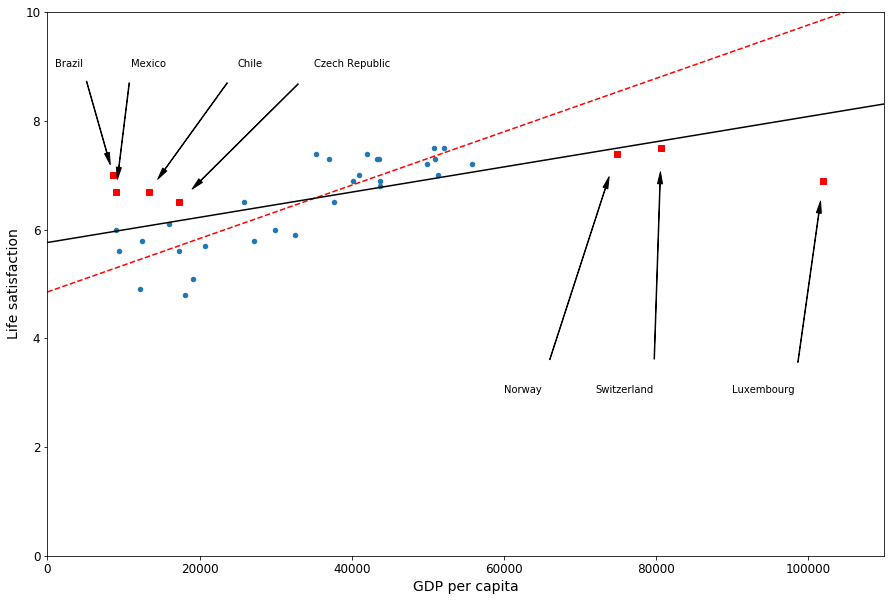

In [ ]:
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(15,10))
plt.axis([0, 110000, 0, 10])

for country, pos_text in position_text2.items():
    pos_data_x, pos_data_y = missing_data.loc[country]
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "rs")

X=np.linspace(0, 110000, 1000)
plt.plot(X, t0 + t1*X, "r--")

lin_reg_full = linear_model.LinearRegression()
Xfull = np.c_[full_country_stats["GDP per capita"]]
yfull = np.c_[full_country_stats["Life satisfaction"]]
lin_reg_full.fit(Xfull, yfull)

t0full, t1full = lin_reg_full.intercept_[0], lin_reg_full.coef_[0][0]
X = np.linspace(0, 110000, 1000)
plt.plot(X, t0full + t1full * X, "k")

plt.show()

# Problem: Fitting der Daten

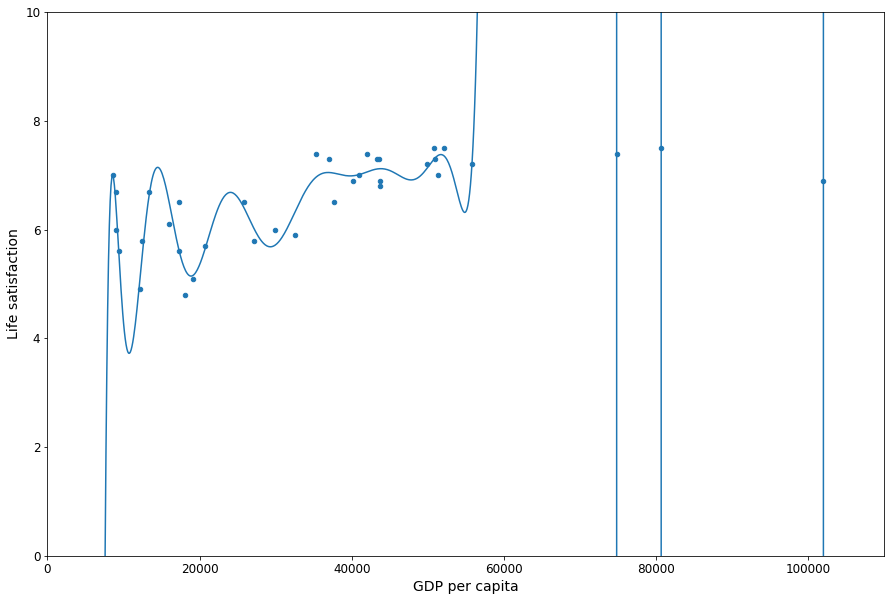

In [ ]:
full_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(15,10))
plt.axis([0, 110000, 0, 10])

from sklearn import preprocessing
from sklearn import pipeline

poly = preprocessing.PolynomialFeatures(degree=20)
scaler = preprocessing.StandardScaler()
lin_reg2 = linear_model.LinearRegression()

pipeline_reg = pipeline.make_pipeline(poly, scaler, lin_reg2)
pipeline_reg.fit(Xfull, yfull)
curve = pipeline_reg.predict(X[:, np.newaxis])
plt.plot(X, curve)
#save_fig('overfitting_model_plot')
plt.show()